## Tape bump assessment (py3). CCD 01
Remember the tape bump is temperature-variation dependent

In [1]:
import os
import time
import numpy as np
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from astropy import time
import easyaccess as ea
# from skimage import data, img_as_float
from skimage.measure import compare_ssim
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize, ZScaleInterval)
%matplotlib notebook

Load the data from basic statistics time series. For *tapebump\_centeright_{band}.npy* files, the statistic was extracted from Y4A1 tag, from 20161013 to 20161101


In [2]:
# Initial set, 20161013t1101
g_stat = np.load('tapebump_centeright_y4a1_g.npy')
r_stat = np.load('tapebump_centeright_y4a1_r.npy')
i_stat = np.load('tapebump_centeright_y4a1_i.npy')
z_stat = np.load('tapebump_centeright_y4a1_z.npy')
Y_stat = np.load('tapebump_centeright_y4a1_Y.npy')
# Larger set, 20161001t1208
g_stat_s2 = np.load('tapebump_centeright_y4a1_20161001t1208_g.npy')
r_stat_s2 = np.load('tapebump_centeright_y4a1_20161001t1208_r.npy')
i_stat_s2 = np.load('tapebump_centeright_y4a1_20161001t1208_i.npy')
z_stat_s2 = np.load('tapebump_centeright_y4a1_20161001t1208_z.npy')
Y_stat_s2 = np.load('tapebump_centeright_y4a1_20161001t1208_Y.npy')

Which fields do the simple stats has?

In [3]:
g_stat.dtype

dtype([('mean', '<f8'), ('median', '<f8'), ('std', '<f8'), ('min', '<i8'), ('max', '<i8'), ('mad', '<f8'), ('rms', '<f8'), ('nite', '<i8'), ('expnum', '<i8'), ('exptime', '<i8'), ('band', 'S10'), ('mjd', '<f8')])

Quick plots for assessment of time periods when the tapebump appears in the image. Then, visualize some of these in a movie-like plotting

In [4]:
days = [np.ptp(x['mjd']) for x in [g_stat, r_stat, i_stat, z_stat, Y_stat]] 

In [5]:
days_s2 = [np.ptp(x['mjd']) for x in [g_stat_s2, r_stat_s2, i_stat_s2, z_stat_s2, Y_stat_s2]] 

### For the smaller set, covering from 20161013 to 20161101

In [6]:
var_y1 = 'mad'
kw1 = {
    's' : 1, 
    'color' : 'blue',
}
fig, ax = plt.subplots(2, 5, figsize=(10, 6.5))
ax[0, 0].scatter(g_stat['mjd'], g_stat[var_y1], **kw1)
ax[0, 1].scatter(r_stat['mjd'], r_stat[var_y1], **kw1)
ax[0, 2].scatter(i_stat['mjd'], i_stat[var_y1], **kw1)
ax[0, 3].scatter(z_stat['mjd'], z_stat[var_y1], **kw1)
ax[0, 4].scatter(Y_stat['mjd'], Y_stat[var_y1], **kw1)
#
kw2 = {
    's' : 1,
    'color' : 'green',
}
ax[1, 0].scatter(g_stat['max'] - g_stat['min'], g_stat['mad'], **kw2)
ax[1, 1].scatter(r_stat['max'] - r_stat['min'], r_stat['mad'], **kw2)
ax[1, 2].scatter(i_stat['max'] - i_stat['min'], i_stat['mad'], **kw2)
ax[1, 3].scatter(z_stat['max'] - z_stat['min'], z_stat['mad'], **kw2)
ax[1, 4].scatter(Y_stat['max'] - Y_stat['min'], Y_stat['mad'], **kw2)
#
bands = ['g', 'r', 'i', 'z', 'Y']
for idx, s in enumerate(ax[0, :]):
    s.set_yscale('log')
    s.set_xlabel('mjd')
    s.set_ylabel('mad')
    s.set_title('{0}-band, {1:.1f} d'.format(bands[idx], days[idx]))
for idx, s in enumerate(ax[1, :]):
    s.set_yscale('log')
    s.set_xlabel('mad')
    s.set_ylabel('max - min')
#    
plt.subplots_adjust(wspace=0.5, left=0.1, right=0.98)

<IPython.core.display.Javascript object>

### A very hands-on selection, small set

Let's start by g-band, using astropy for imashow color scaling. 

In [7]:
sel_g = g_stat[np.where(np.logical_and((g_stat['max'] - g_stat['min']) > 50, g_stat['mad'] > 0.4))]
# works too: [np.where(g_stat['mean'] < 0.4)]
# [np.where(g_stat['mad'] > 0.4)]
# [np.where(g_stat['min'] < -2)]
# [np.where(np.logical_and((g_stat['max'] - g_stat['min']) > 50, g_stat['mean'] < 0))]
sel_g_path = ['stamps/tape_centeright-y4a1_g_D00{0}.npy'.format(e) for e in sel_g['expnum']]

r-band

In [8]:
sel_r = r_stat[np.where(np.logical_and((r_stat['max'] - r_stat['min']) > 50, r_stat['mad'] > 0.4))]
sel_r_path = ['stamps/tape_centeright-y4a1_r_D00{0}.npy'.format(e) for e in sel_r['expnum']]

i-band

In [9]:
sel_i = i_stat[np.where(np.logical_and((i_stat['max'] - i_stat['min']) > 50, i_stat['mad'] > 0.4))]
sel_i_path = ['stamps/tape_centeright-y4a1_i_D00{0}.npy'.format(e) for e in sel_i['expnum']]

z-band

In [10]:
sel_z = z_stat[np.where(np.logical_and((z_stat['max'] - z_stat['min']) > 50, z_stat['mad'] > 0.4))]
sel_z_path = ['stamps/tape_centeright-y4a1_z_D00{0}.npy'.format(e) for e in sel_z['expnum']]

Y-band

In [11]:
sel_Y = Y_stat[np.where(np.logical_and((Y_stat['max'] - Y_stat['min']) > 20, Y_stat['mad'] > 0.4))]
sel_Y_path = ['stamps/tape_centeright-y4a1_Y_D00{0}.npy'.format(e) for e in sel_Y['expnum']]

In [12]:
print('Number of selected per band: g={0}, r={1}, z={2}, Y={3}'.format(sel_g.size, 
                                                                       sel_r.size, 
                                                                       sel_i.size,
                                                                       sel_z.size,
                                                                       sel_Y.size))

Number of selected per band: g=21, r=24, z=92, Y=77


Set animated plots 

In [13]:
def visual_sequence(path_list, anim_interval=200, anim_repeat=False, anim_save=False, outfnm=None):
    ''' Function to receive a list of full paths to files to be 
    displayed in order, in overlapping sequence.
    '''
    fig = plt.figure()
    ims = []
    for i in path_list:
        aux_x = np.load(i)
        # Normalize image, using astropy zscale for range, and square root for 
        # stretching (?)
        im_norm = ImageNormalize(aux_x, 
                                 interval=ZScaleInterval(),
                                 stretch=SqrtStretch())
        # Append each of the plots to a list
        kw  = {
            'origin' : 'lower', 
            'animated' : True, 
            'cmap' : 'gray_r',
        }
        im = plt.imshow(aux_x, norm=im_norm, **kw)
        ims.append([im])
    # Using the plot-populated list, create the animation
    # blitting (True/False) useful when the frame can be slightly modified to 
    # create the next frame
    ani = animation.ArtistAnimation(fig, ims, 
                                    interval=anim_interval, 
                                    blit=True,
                                    repeat_delay=1000, 
                                    repeat=anim_repeat)
    if anim_save:
        if (outfnm is None):
            outfnm = 'pid{0}.mp4'.format(os.getpid())
        # Set up formatting for the movie files
        aux_wr1 = animation.writers['ffmpeg']
        aux_writer = aux_wr1(fps=15, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000, dpi=300)
        ani.save(outfnm, writer=aux_writer)
    else:
        plt.show()

## Plots for the small set, covering ~15 days

In [14]:
path_list = sel_g_path
anim_interval = 200
anim_repeat = False
anim_save = True
outfnm = 'g_tapebump_c01.mp4'
#
fig = plt.figure()
ims = []
for i in path_list:
    aux_x = np.load(i)
    # Normalize image, using astropy zscale for range, and square root for 
    # stretching (?)
    im_norm = ImageNormalize(aux_x, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    # Append each of the plots to a list
    kw  = {
        'origin' : 'lower', 
        'animated' : True, 
        'cmap' : 'gray_r',
    }
    im = plt.imshow(aux_x, norm=im_norm, **kw)
    ims.append([im])
# Using the plot-populated list, create the animation
# blitting (True/False) useful when the frame can be slightly modified to 
# create the next frame
ani = animation.ArtistAnimation(fig, ims, 
                                interval=anim_interval, 
                                blit=True,
                                repeat_delay=1000, 
                                repeat=anim_repeat)
plt.colorbar()
plt.suptitle('g-band, CCD 1, middle-right tapebump', color='dodgerblue')
if anim_save:
    if (outfnm is None):
        outfnm = 'pid{0}.mp4'.format(os.getpid())
    # Set up formatting for the movie files
    aux_wr1 = animation.writers['ffmpeg']
    aux_writer = aux_wr1(fps=5, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000)
    ani.save(outfnm, writer=aux_writer)
    # plt.show()
else:
    plt.show()

<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: 'stamps/tape_centeright-y4a1_g_D00583835.npy'

<IPython.core.display.Javascript object>


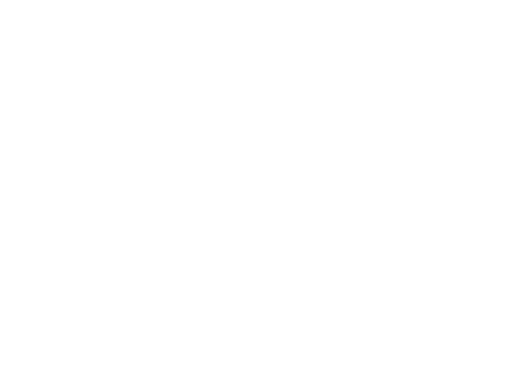

FileNotFoundError: [Errno 2] No such file or directory: 'stamps/tape_centeright-y4a1_r_D00583751.npy'

In [15]:
path_list = sel_r_path
anim_interval = 200
anim_repeat = False
anim_save = True
outfnm = 'r_tapebump_c01.mp4'
#
fig = plt.figure()
ims = []
for i in path_list:
    aux_x = np.load(i)
    # Normalize image, using astropy zscale for range, and square root for 
    # stretching (?)
    im_norm = ImageNormalize(aux_x, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    # Append each of the plots to a list
    kw  = {
        'origin' : 'lower', 
        'animated' : True, 
        'cmap' : 'gray_r',
    }
    im = plt.imshow(aux_x, norm=im_norm, **kw)
    ims.append([im])
# Using the plot-populated list, create the animation
# blitting (True/False) useful when the frame can be slightly modified to 
# create the next frame
ani = animation.ArtistAnimation(fig, ims, 
                                interval=anim_interval, 
                                blit=True,
                                repeat_delay=1000, 
                                repeat=anim_repeat)
plt.suptitle('r-band, CCD 1, middle-right tapebump', color='dodgerblue')
plt.colorbar()
if anim_save:
    if (outfnm is None):
        outfnm = 'pid{0}.mp4'.format(os.getpid())
    # Set up formatting for the movie files
    aux_wr1 = animation.writers['ffmpeg']
    aux_writer = aux_wr1(fps=5, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000)
    ani.save(outfnm, writer=aux_writer)
    # plt.show()
else:
    plt.show()

In [ ]:
path_list = sel_i_path
anim_interval = 200
anim_repeat = False
anim_save = True
outfnm = 'i_tapebump_c01.mp4'
#
fig = plt.figure()
ims = []
for i in path_list:
    aux_x = np.load(i)
    # Normalize image, using astropy zscale for range, and square root for 
    # stretching (?)
    im_norm = ImageNormalize(aux_x, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    # Append each of the plots to a list
    kw  = {
        'origin' : 'lower', 
        'animated' : True, 
        'cmap' : 'gray_r',
    }
    im = plt.imshow(aux_x, norm=im_norm, **kw)
    ims.append([im])
# Using the plot-populated list, create the animation
# blitting (True/False) useful when the frame can be slightly modified to 
# create the next frame
ani = animation.ArtistAnimation(fig, ims, 
                                interval=anim_interval, 
                                blit=True,
                                repeat_delay=1000, 
                                repeat=anim_repeat)
plt.suptitle('i-band, CCD 1, middle-right tapebump', color='dodgerblue')
plt.colorbar()
if anim_save:
    if (outfnm is None):
        outfnm = 'pid{0}.mp4'.format(os.getpid())
    # Set up formatting for the movie files
    aux_wr1 = animation.writers['ffmpeg']
    aux_writer = aux_wr1(fps=5, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000)
    ani.save(outfnm, writer=aux_writer)
    plt.show()
else:
    plt.show()

<IPython.core.display.Javascript object>


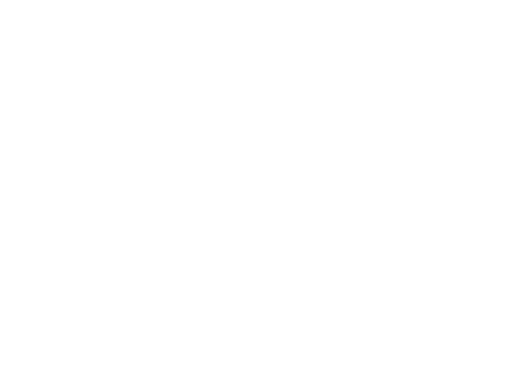

FileNotFoundError: [Errno 2] No such file or directory: 'stamps/tape_centeright-y4a1_z_D00583766.npy'

In [16]:
path_list = sel_z_path
anim_interval = 200
anim_repeat = False
anim_save = True
outfnm = 'z_tapebump_c01.mp4'
#
fig = plt.figure()
ims = []
for i in path_list:
    aux_x = np.load(i)
    # Normalize image, using astropy zscale for range, and square root for 
    # stretching (?)
    im_norm = ImageNormalize(aux_x, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    # Append each of the plots to a list
    kw  = {
        'origin' : 'lower', 
        'animated' : True, 
        'cmap' : 'gray_r',
    }
    im = plt.imshow(aux_x, norm=im_norm, **kw)
    ims.append([im])
# Using the plot-populated list, create the animation
# blitting (True/False) useful when the frame can be slightly modified to 
# create the next frame
ani = animation.ArtistAnimation(fig, ims, 
                                interval=anim_interval, 
                                blit=True,
                                repeat_delay=1000, 
                                repeat=anim_repeat)
plt.suptitle('z-band, CCD 1, middle-right tapebump', color='dodgerblue')
plt.colorbar()
if anim_save:
    if (outfnm is None):
        outfnm = 'pid{0}.mp4'.format(os.getpid())
    # Set up formatting for the movie files
    aux_wr1 = animation.writers['ffmpeg']
    aux_writer = aux_wr1(fps=5, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000)
    ani.save(outfnm, writer=aux_writer)
    plt.show()
else:
    plt.show()

In [ ]:
path_list = sel_Y_path
anim_interval = 200
anim_repeat = False
anim_save = True
outfnm = 'Y_tapebump_c01.mp4'
#
fig = plt.figure()
ims = []
for i in path_list:
    aux_x = np.load(i)
    # Normalize image, using astropy zscale for range, and square root for 
    # stretching (?)
    im_norm = ImageNormalize(aux_x, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    # Append each of the plots to a list
    kw  = {
        'origin' : 'lower', 
        'animated' : True, 
        'cmap' : 'gray_r',
    }
    im = plt.imshow(aux_x, norm=im_norm, **kw)
    ims.append([im])
# Using the plot-populated list, create the animation
# blitting (True/False) useful when the frame can be slightly modified to 
# create the next frame
ani = animation.ArtistAnimation(fig, ims, 
                                interval=anim_interval, 
                                blit=True,
                                repeat_delay=1000, 
                                repeat=anim_repeat)
plt.suptitle('Y-band, CCD 1, middle-right tapebump', color='dodgerblue')
plt.colorbar()
if anim_save:
    if (outfnm is None):
        outfnm = 'pid{0}.mp4'.format(os.getpid())
    # Set up formatting for the movie files
    aux_wr1 = animation.writers['ffmpeg']
    aux_writer = aux_wr1(fps=5, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000)
    ani.save(outfnm, writer=aux_writer)
    plt.show()
else:
    plt.show()

## Now for the larger set, from 20161001 to 20171208

### Diagnosis plot for the larger set, covering from 20161001 to 20161208

<IPython.core.display.Javascript object>


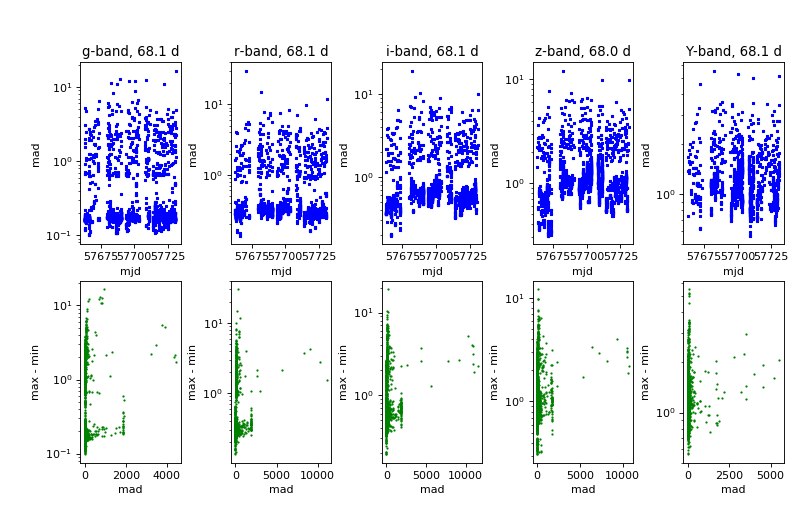

In [17]:
var_y1 = 'mad'
kw1 = {
    'marker' : 's',
    's' : 1, 
    'color' : 'blue',
}
fig, ax = plt.subplots(2, 5, figsize=(10, 6.5))
ax[0, 0].scatter(g_stat_s2['mjd'], g_stat_s2[var_y1], **kw1)
ax[0, 1].scatter(r_stat_s2['mjd'], r_stat_s2[var_y1], **kw1)
ax[0, 2].scatter(i_stat_s2['mjd'], i_stat_s2[var_y1], **kw1)
ax[0, 3].scatter(z_stat_s2['mjd'], z_stat_s2[var_y1], **kw1)
ax[0, 4].scatter(Y_stat_s2['mjd'], Y_stat_s2[var_y1], **kw1)
#
kw2 = {
    's' : 1,
    'color' : 'green',
}
ax[1, 0].scatter(g_stat_s2['max'] - g_stat_s2['min'], g_stat_s2['mad'], **kw2)
ax[1, 1].scatter(r_stat_s2['max'] - r_stat_s2['min'], r_stat_s2['mad'], **kw2)
ax[1, 2].scatter(i_stat_s2['max'] - i_stat_s2['min'], i_stat_s2['mad'], **kw2)
ax[1, 3].scatter(z_stat_s2['max'] - z_stat_s2['min'], z_stat_s2['mad'], **kw2)
ax[1, 4].scatter(Y_stat_s2['max'] - Y_stat_s2['min'], Y_stat_s2['mad'], **kw2)
#
bands = ['g', 'r', 'i', 'z', 'Y']
for idx, s in enumerate(ax[0, :]):
    s.set_yscale('log')
    s.set_xlabel('mjd')
    s.set_ylabel('mad')
    s.set_title('{0}-band, {1:.1f} d'.format(bands[idx], days_s2[idx]))
for idx, s in enumerate(ax[1, :]):
    s.set_yscale('log')
    s.set_xlabel('mad')
    s.set_ylabel('max - min')
#    
plt.subplots_adjust(wspace=0.5, left=0.1, right=0.98)

### A very handcrafted selection

In [18]:
sel_g_s2 = g_stat_s2[np.where(np.logical_and((g_stat_s2['max'] - g_stat_s2['min']) > 50, g_stat_s2['mad'] > 0.4))]
sel_g_s2_path = ['stamps_20161001t1208/tape_centeright-y4a1-20161001t1208_g_D00{0}.npy'.format(e) 
                 for e in sel_g_s2['expnum']]

<IPython.core.display.Javascript object>


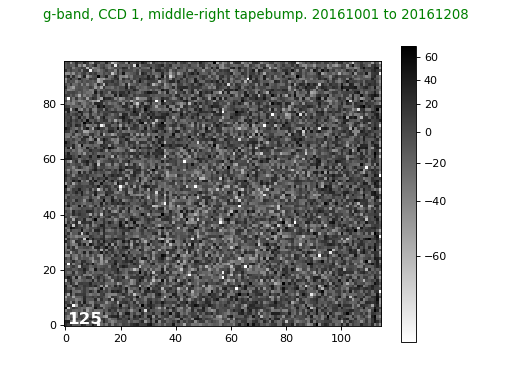

/Users/fco/anaconda3/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/fco/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


In [19]:
path_list = sel_g_s2_path
anim_interval = 200
anim_repeat = False
anim_save = True
outfnm = 'g_tapebump_20161001t1208.mp4'
#

fig = plt.figure()
ims = []
cnt = 1
for i in path_list:
    aux_x = np.load(i)
    # Normalize image, using astropy zscale for range, and square root for 
    # stretching (?)
    im_norm = ImageNormalize(aux_x, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    # Append each of the plots to a list
    kw  = {
        'origin' : 'lower', 
        'animated' : True, 
        'cmap' : 'gray_r',
    }
    im = plt.imshow(aux_x, norm=im_norm, label=i, **kw)
    imaux = plt.text(0.5, 0.5, '{0}'.format(cnt), fontweight='bold', color='w', fontsize=15)
    ims.append([im, imaux])
    cnt += 1
# Using the plot-populated list, create the animation
# blitting (True/False) useful when the frame can be slightly modified to 
# create the next frame
ani = animation.ArtistAnimation(fig, ims, 
                                interval=anim_interval, 
                                blit=True,
                                repeat_delay=1000, 
                                repeat=anim_repeat)
plt.colorbar()
plt.suptitle('g-band, CCD 1, middle-right tapebump. 20161001 to 20161208', color='green')
plt.legend()
if anim_save:
    if (outfnm is None):
        outfnm = 'pid{0}.mp4'.format(os.getpid())
    # Set up formatting for the movie files
    aux_wr1 = animation.writers['ffmpeg']
    aux_writer = aux_wr1(fps=5, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000)
    ani.save(outfnm, writer=aux_writer)
    # plt.show()
else:
    plt.show()

### Visual inspecting the generateed movies, generate a list of 'pure' highlighted tapebumps

In [21]:
g_s2_idx = [11, 12, 13, 14, 15, 19, 21, 28, 31, 32, 42, 45, 46, 56, 58, 76, 107, 114, 118, 119, 123]
len(g_s2_idx)

21

Use the visually selected stamps to make a new selection

**List of paths of the selection used to construct the median image**

In [22]:
cnt = 0
selection_path = []
for i in g_s2_idx:
    p = sel_g_s2_path[i]
    selection_path.append(p)
    if (cnt == 0):
        x3d = np.load(p)
    else:
        x3d = np.dstack((x3d, np.load(p)))
    cnt += 1

Function to construct the median of stacked stamps

In [23]:
def stat_cube(x3d, func):
    ''' Function to calculate the median image per pixel, using an input 
    3dimensional array containing the stamps on which to work.
    Uses numpy iteration tools
    Example for easy usage:
    x3d = np.dstack(array_i)
    x_median = stat_cube(x3d, (lambda: np.median)())
    '''
    out = np.zeros_like(x3d[:, :, 0])
    it = np.nditer(x3d[:, :, 0], flags=['multi_index'])
    while not it.finished:
        i1, i2 = it.multi_index
        out[i1, i2] = func(x3d[i1, i2, :])
        it.iternext()
    return out

Median image

In [24]:
z_median = stat_cube(x3d, (lambda: np.median)())

<IPython.core.display.Javascript object>


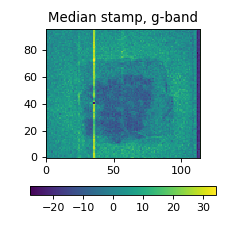

In [25]:
fig, ax = plt.subplots(figsize=(3, 3))
im = ax.imshow(z_median, origin='lower')
ax.set_title('Median stamp, g-band')
plt.colorbar(im, orientation='horizontal')

## Using the median image stamp, make a ratio-based selection using MAD

In [26]:
all_g_s2_path = ['stamps_20161001t1208/tape_centeright-y4a1-20161001t1208_g_D00{0}.npy'.format(e) 
                 for e in g_stat_s2['expnum']]

In [29]:
g_ratio = []
for p in all_g_s2_path:
    # tmp_x = np.std(np.load(p) / z_median)
    tmp_x = np.load(p) / z_median
    tmp_x = np.median(np.abs(tmp_x - np.median(tmp_x)))
    g_ratio.append(tmp_x)

In [30]:
len(g_ratio), g_stat_s2['mjd'].shape

(2771, (2771,))

<IPython.core.display.Javascript object>


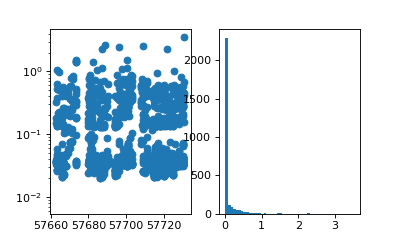

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(5, 3))
ax[0].scatter(g_stat_s2['mjd'], g_ratio)
ax[1].hist(g_ratio, bins=50)
ax[0].set_yscale('log')

In [50]:
# Idea:
# to get the images that has lower MAD and construct a library from them. First I need to plot them for checking
# Ranges: mad < 0.03, 0.03 <= mad < 0.05, 0.05 <= mad < 0.2, mad > 0.2
idx_mad = np.where(np.array(g_ratio) <= 0.03)
#(np.logical_and(np.array(g_ratio) >= 0.05, np.array(g_ratio) < 0.2))
set1_path = np.array(all_g_s2_path)[idx_mad]

<IPython.core.display.Javascript object>


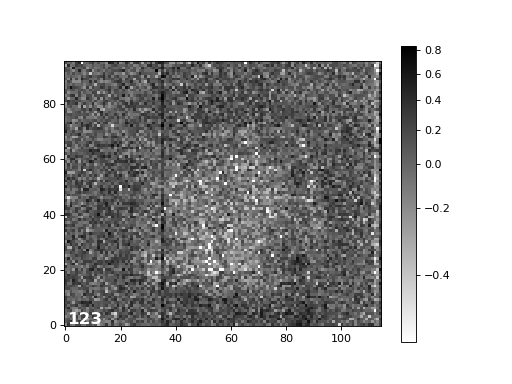

/Users/fco/anaconda3/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/fco/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


In [34]:
path_list = set1_path
anim_interval = 200
anim_repeat = False
anim_save = True
outfnm = 'set_madlt003.mp4'
#

fig = plt.figure()
ims = []
cnt = 1
for i in path_list:
    aux_x = np.load(i)
    # Normalize image, using astropy zscale for range, and square root for 
    # stretching (?)
    im_norm = ImageNormalize(aux_x, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    # Append each of the plots to a list
    kw  = {
        'origin' : 'lower', 
        'animated' : True, 
        'cmap' : 'gray_r',
    }
    im = plt.imshow(aux_x, norm=im_norm, label=i, **kw)
    imaux = plt.text(0.5, 0.5, '{0}'.format(cnt), fontweight='bold', color='w', fontsize=15)
    ims.append([im, imaux])
    cnt += 1
# Using the plot-populated list, create the animation
# blitting (True/False) useful when the frame can be slightly modified to 
# create the next frame
ani = animation.ArtistAnimation(fig, ims, 
                                interval=anim_interval, 
                                blit=True,
                                repeat_delay=1000, 
                                repeat=anim_repeat)
plt.colorbar()
#plt.suptitle('g-band, CCD 1, middle-right tapebump. 20161001 to 20161208', color='green')
plt.legend()
if anim_save:
    if (outfnm is None):
        outfnm = 'pid{0}.mp4'.format(os.getpid())
    # Set up formatting for the movie files
    aux_wr1 = animation.writers['ffmpeg']
    aux_writer = aux_wr1(fps=5, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000)
    ani.save(outfnm, writer=aux_writer)
    # plt.show()
else:
    plt.show()


### From the above ranges (0.03/0.05/0.2), the most consistent was the range for `MAD<0.03`. The problem is: this range exhibits only faint tapebumps.

In [35]:
print( '{0} selected stamps in common'.format( len(set(set1_path).intersection(set(selection_path))) ) )

0 selected stamps in common


If even the original stamps used for construct the medin image were not included, then this is a good test to say the classificator is not good enough

## Another metric, norm for the difference between each stamp and the median image

In [36]:
aux_norm = []
for p in all_g_s2_path:
    tmp = np.load(p)
    aux_norm.append( scipy.linalg.norm(tmp - z_median, ord='fro') )

<IPython.core.display.Javascript object>


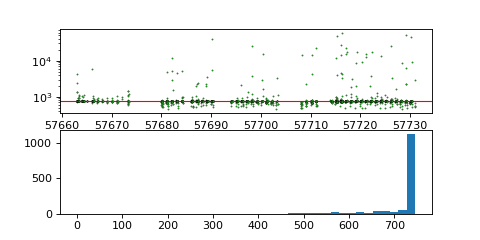

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(6, 3))
ax[0].scatter(g_stat_s2['mjd'], aux_norm, marker='.', color='forestgreen', s=8, edgecolor='k', linewidth=0.1)
ax[0].axhline(np.median(aux_norm), color='r', linewidth=1, zorder=0)
ax[1].hist(aux_norm, range=[0, np.median(aux_norm)], bins=40)
ax[0].set_yscale('log')

In [ ]:
# Lets set a cut below the median
idx_aux = np.where(np.array(aux_norm) < 700)
y1 = np.array(all_g_s2_path)[idx_aux]
y2 = np.array(aux_norm)[idx_aux]
# Remove first 11
y1 = y1[12:]
y2 = y2[12:]

path_list = y1
anim_interval = 200
anim_repeat = False
anim_save = True
#
fig = plt.figure()
ims = []
cnt = 1
for i in path_list:
    aux_x = np.load(i)
    # Normalize image, using astropy zscale for range, and square root for 
    # stretching (?)
    im_norm = ImageNormalize(aux_x, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    # Append each of the plots to a list
    kw  = {
        'origin' : 'lower', 
        'animated' : True, 
        'cmap' : 'gray_r',
    }
    im = plt.imshow(aux_x, norm=im_norm, label=i, **kw)
    imaux = plt.text(0.5, 0.5, '{0} / norm:{1:.2f}'.format(cnt, y2[cnt-1]), 
                     fontweight='bold', color='w', fontsize=15)
    ims.append([im, imaux])
    cnt += 1
# Using the plot-populated list, create the animation
# blitting (True/False) useful when the frame can be slightly modified to 
# create the next frame
ani = animation.ArtistAnimation(fig, ims, 
                                interval=anim_interval, 
                                blit=True,
                                repeat_delay=1000, 
                                repeat=anim_repeat)
plt.colorbar()
#plt.suptitle('g-band, CCD 1, middle-right tapebump. 20161001 to 20161208', color='green')
plt.legend()
plt.show()

### This metric works better than the ratio-based. It selects more prominent tapebumps. We can use this result, after discard some few (11)

## Additional similarity metrics *structural similarity index*

### As stars are present, the min-max inerval is not useful. Use instead the zscale

The structural similarity index is *An image quality metric that assesses the visual impact of three characteristics of an image: luminance, contrast and structure* (Mathworks definition)

Save a dtaframe with the results of SSIM

In [51]:
comp = []
aux_expnum = []
aux_mjd = []
aux_path = []
for p in all_g_s2_path:
    tmp = np.load(p)
    # Calculate the ZScale
    aux_norm = ImageNormalize(tmp, 
                              interval=ZScaleInterval(),)
    aux_ssim = compare_ssim(z_median, 
                            tmp, 
                            data_range=aux_norm.vmax - aux_norm.vmin)
    comp.append(aux_ssim)
    # 
    aux_expnum.append(int(p[-12:-4]))
    aux_mjd.append(g_stat_s2['mjd'][ np.where(g_stat_s2['expnum'] == int(p[-12:-4])) ])
    aux_path.append(p)
comp = np.array(comp)
df_ssim = pd.DataFrame({'ssim' : comp, 
                        'mjd' : aux_expnum, 
                        'expnum' : aux_expnum,
                        'path' : aux_path,})

In [52]:
df_ssim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 4 columns):
expnum    2771 non-null int64
mjd       2771 non-null int64
path      2771 non-null object
ssim      2771 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 86.7+ KB


Quick assessment plot to get the lower cut for the index values

<IPython.core.display.Javascript object>


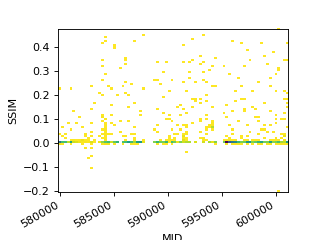

In [53]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.hist2d(df_ssim['mjd'], df_ssim['ssim'], bins=80, cmin=1, cmap='viridis_r')
ax.set_xlabel('MJD')
ax.set_ylabel('SSIM')

plt.gcf().autofmt_xdate()

plt.subplots_adjust(left=0.18, bottom=0.2)
plt.show()

With the cut value, get the set of stamps better matching my set

<IPython.core.display.Javascript object>


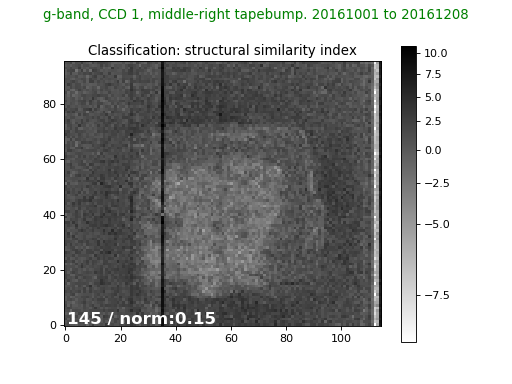

In [54]:
ssim_cutval = 0.1

# idx = np.where(np.array(comp) >= ssim_cutval)
# y1 = np.array(all_g_s2_path)[idx]
# y2 = comp[idx]

df_ssim_a = df_ssim.loc[df_ssim.ssim >= ssim_cutval]

# For plotting
anim_interval = 200
anim_repeat = False
anim_save = True
outfnm = 'set_ssim_gt01.mp4'

fig = plt.figure()
ims = []
cnt = 1
for i in df_ssim_a['path']:
    aux_x = np.load(i)
    im_norm = ImageNormalize(aux_x, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch(),)
    # Append each of the plots to a list
    kw  = {
        'origin' : 'lower', 
        'animated' : True, 
        'cmap' : 'gray_r',
    }
    im = plt.imshow(aux_x, norm=im_norm, label=i, **kw)
    imaux = plt.text(0.5, 0.5, 
                     '{0} / norm:{1:.2f}'.format(cnt, df_ssim_a['ssim'].values[cnt-1]), 
                     fontweight='bold', color='w', fontsize=15)
    ims.append([im, imaux])
    cnt += 1
# Using the plot-populated list, create the animation
# blitting (True/False) useful when the frame can be slightly modified to 
# create the next frame
ani = animation.ArtistAnimation(fig, ims, 
                                interval=anim_interval, 
                                blit=True,
                                repeat_delay=1000, 
                                repeat=anim_repeat)
plt.colorbar()
plt.suptitle('g-band, CCD 1, middle-right tapebump. 20161001 to 20161208', color='green')
plt.title('Classification: structural similarity index')
plt.legend()

if anim_save:
    if (outfnm is None):
        outfnm = 'pid{0}.mp4'.format(os.getpid())
    # Set up formatting for the movie files
    aux_wr1 = animation.writers['ffmpeg']
    aux_writer = aux_wr1(fps=5, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000)
    ani.save(outfnm, writer=aux_writer)

plt.show()

Using the above defined indices for the selected values, jointly plot the main sample and the selection

NOTE: change the usage of arrays to the df_ssim

<IPython.core.display.Javascript object>


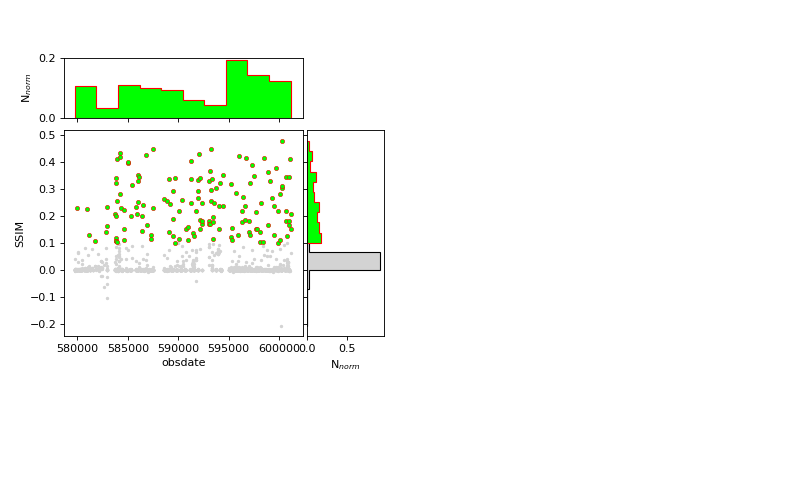

[]

In [82]:
fig = plt.figure(figsize=(10,6))

gs1 = gridspec.GridSpec(4, 4)
gs1.update(left=0.08, right=0.48, wspace=0.05, bottom=0.3)
ax1 = fig.add_subplot(gs1[1: , :-1])
ax2 = fig.add_subplot(gs1[1: , -1:])#, sharey=ax1)
ax3 = fig.add_subplot(gs1[0 , :-1])#, sharex=ax1)

# Main set
kw1 = {
    'color' : 'lightgray',
    's' : 4,
}
ax1.scatter(df_ssim['mjd'], df_ssim['ssim'], **kw1)
# Selection
kw2 = {
    'color' : 'lime',
    's' : 15,
    'edgecolor' : 'red',
    'lw' : 0.5,
}
ax1.scatter(df_ssim.loc[df_ssim['ssim'] > ssim_cutval, 'mjd'], 
            df_ssim.loc[df_ssim['ssim'] > ssim_cutval, 'ssim'], 
            **kw2)

# Histogram for both samples
waux1 = np.ones(len(df_ssim.index)) / len(df_ssim.index) #comp.size
ax2.hist(df_ssim['ssim'], 
         orientation='horizontal', weights=waux1, histtype='stepfilled', 
         color='lightgray', edgecolor='k')
aux_n = len(df_ssim.loc[df_ssim['ssim'] > ssim_cutval].index)
waux2 = np.ones(aux_n) / aux_n
ax2.hist(df_ssim.loc[df_ssim['ssim'] > ssim_cutval, 'ssim'], 
         orientation='horizontal', weights=waux2, histtype='stepfilled', 
         color='lime', edgecolor='r')
#
waux3 = np.ones_like(df_ssim['mjd'].values) / df_ssim['mjd'].values.size
ax3.hist(df_ssim['mjd'], orientation='vertical', weights=waux3, 
         histtype='stepfilled', color='lime', edgecolor='r')

# If sharing axis, then when removing labels from one subplot, the
# other gtes its labels removed too
ax2.set_ylim(ax1.set_ylim())
ax3.set_xlim(ax1.get_xlim())

# Data labels
ax1.set_xlabel('obsdate')
ax1.set_ylabel('SSIM')
ax2.set_xlabel(r'N$_{norm}$')
ax3.set_ylabel(r'N$_{norm}$')

# Remove axis labels
ax2.set_yticklabels([])
ax3.set_xticklabels([])


## Compare against DB quality assessments for these exposures

In [83]:
q = 'select e.nite, qa.expnum, qa.t_eff, qa.psf_fwhm, qa.skybrightness,'
q += ' qa.f_eff, qa.b_eff, qa.c_eff, qa.skytilt, qa.astrom_sigma,'
q += ' qa.astrom_offset, qa.astrom_ndets, qa.astrom_chi2, qa.nobjects,'
q += ' qa.flag, qa.calnac, qa.cloud_des, qa.n_des'
q += ' from exposure e, qa_summary qa'
q += ' where e.nite between 20161001 and 20161208'
q += ' and e.expnum=qa.expnum'

In [84]:
connection = ea.connect('desoper')

Connecting to DB ** desoper ** ...


In [85]:
df_qa = connection.query_to_pandas(q)

Lowercase the column names

In [86]:
df_qa.columns = df_qa.columns.map(str.lower)

In [87]:
df_qa.columns

Index(['nite', 'expnum', 't_eff', 'psf_fwhm', 'skybrightness', 'f_eff', 'b_eff', 'c_eff', 'skytilt', 'astrom_sigma', 'astrom_offset', 'astrom_ndets', 'astrom_chi2', 'nobjects', 'flag', 'calnac', 'cloud_des', 'n_des'], dtype='object')

In [88]:
# Inner join with the DB assessment
df_xm = pd.merge(df_ssim, df_qa, how='inner', on='expnum')

In [89]:
df_xm.info(), df_ssim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2780 entries, 0 to 2779
Data columns (total 21 columns):
expnum           2780 non-null int64
mjd              2780 non-null int64
path             2780 non-null object
ssim             2780 non-null float64
nite             2780 non-null object
t_eff            2780 non-null float64
psf_fwhm         2780 non-null float64
skybrightness    2780 non-null float64
f_eff            2780 non-null float64
b_eff            2780 non-null float64
c_eff            2780 non-null float64
skytilt          2780 non-null float64
astrom_sigma     2780 non-null float64
astrom_offset    2780 non-null float64
astrom_ndets     2780 non-null int64
astrom_chi2      2780 non-null float64
nobjects         2780 non-null int64
flag             2780 non-null int64
calnac           2780 non-null int64
cloud_des        2652 non-null float64
n_des            2652 non-null float64
dtypes: float64(13), int64(6), object(2)
memory usage: 477.8+ KB
<class 'pandas.core.fra

(None, None)

<IPython.core.display.Javascript object>


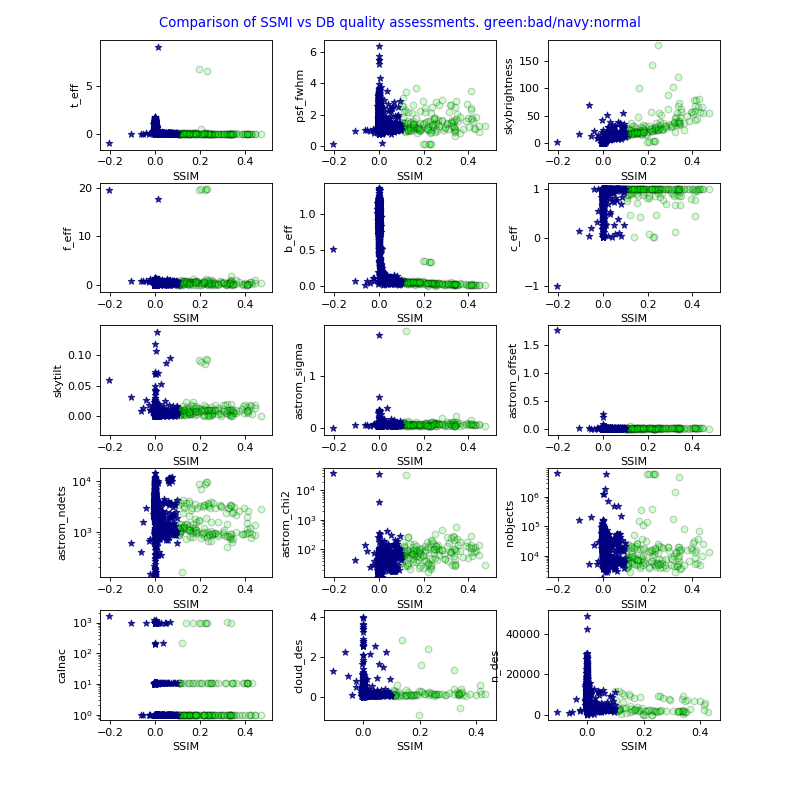

In [91]:
daux_a = df_xm.loc[df_xm['ssim'] > ssim_cutval]
daux_b = df_xm.loc[df_xm['ssim'] <= ssim_cutval]
#
fig, ax = plt.subplots(5, 3, figsize=(10, 10))
ax = ax.ravel()

params = ['t_eff', 'psf_fwhm', 'skybrightness', 
          'f_eff', 'b_eff', 'c_eff', 'skytilt', 
          'astrom_sigma', 'astrom_offset', 
          'astrom_ndets', 'astrom_chi2', 
          'nobjects', 'calnac', 'cloud_des', 
          'n_des',]
cnt = 0
for axy in ax:
    p = params[cnt]
    axy.scatter(daux_a['ssim'], daux_a[p], color='lime', edgecolor='k', alpha=0.2)
    axy.scatter(daux_b['ssim'], daux_b[p], color='navy', marker='*', alpha=0.8, zorder=1)
    axy.set_xlabel('SSIM')
    axy.set_ylabel(p)
    if (np.max(daux_b[p].values) > 100):
        axy.set_yscale('log')
    cnt += 1

plt.suptitle('Comparison of SSMI vs DB quality assessments. green:bad/navy:normal', color='b')
plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.95, bottom=0.1)


I need to compare to 2 populations, with the `SSIM > 0.25` and with the rest

## SSIM worked well. Join the list with the visually selected.

Path list

In [ ]:
sel_stamp_path = np.r_[df_ssim['path'].values, np.array(selection_path)]
sel_stamp_path = np.unique(sel_stamp_path)

Save list to a text file

In [ ]:
aux_out = 'stamps_PID{0}.txt'.format(os.getpid())
np.savetxt(aux_out, sel_stamp_path, fmt='%s')

In [ ]:
len(selection_path), df_ssim['path'].values.size, sel_stamp_path.size

Expnums and stat values

In [ ]:
l_expnum = [int(p[-12:-4]) for p in sel_stamp_path]
l_g_stat = g_stat_s2[np.isin(g_stat_s2['expnum'], l_expnum)]

In [ ]:
l_g_stat['nite'].min(), l_g_stat['nite'].max()

**NOTE: The time plot works for scatter, but I did not make it work for the histogram**

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
# Time conversion: MJD to time
t = time.Time(l_g_stat['mjd'], format='mjd', scale='utc')
kw1 = {
    'color' : 'lime',
    'xdate' : True,
    'marker' : 'o',
    'markersize' : 6,
    'markeredgecolor' : 'red',
}
ax.plot_date(t.plot_date,  **kw1)

# Rotate labels
plt.setp( ax.xaxis.get_majorticklabels(), rotation=40 )

ax.set_xlabel('obsdate')
ax.set_ylabel('SSIM')
ax.set_title('SSIM Selection')

plt.subplots_adjust(bottom=0.3)